# Preprocesamiento de Datos de Voz - Ibarra et al. (2023)

## Pipeline Exacto según Paper

Este notebook implementa el preprocesamiento exacto descrito en Ibarra et al. (2023):

### Pipeline (sin augmentation):
1. **Resample**: 44.1 kHz
2. **Normalización**: Por amplitud máxima absoluta
3. **Segmentación**: Ventanas de 400ms con 50% overlap
4. **Mel Spectrogram**: 65 bandas, hop 10ms, ventana FFT 40ms
5. **Conversión**: Amplitud a dB
6. **Normalización**: Z-score por espectrograma
7. **Dimensión final**: 65×41 píxeles

### Output:
- Espectrogramas individuales (65×41) guardados en cache
- Reutilizables para CNN2D y Time-CNN-LSTM
- Cache en `cache/healthy_ibarra.pkl` y `cache/parkinson_ibarra.pkl`

### Uso:
Los espectrogramas pueden usarse directamente para:
- **CNN2D**: Un espectrograma por input
- **Time-CNN-LSTM**: Secuencias de n espectrogramas con padding/masking


## 1. Setup y Configuración


In [1]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.core import preprocessing
from modules.core.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW, TARGET_FRAMES,
    print_preprocessing_config
)
from modules.core.dataset import (
    process_dataset,
    to_pytorch_tensors,
    parse_filename,
    save_spectrograms_cache,
    load_spectrograms_cache
)
from modules.core.visualization import (
    visualize_audio_and_spectrograms,
    plot_spectrogram_comparison
)

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*70)
print("PREPROCESAMIENTO IBARRA ET AL. (2023)")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"📦 Librosa: {librosa.__version__}")
print("="*70)

# Mostrar configuración de preprocesamiento
print("\n")
print_preprocessing_config()
print("="*70)


PREPROCESAMIENTO IBARRA ET AL. (2023)
✅ Librerías cargadas correctamente
📦 Librosa: 0.11.0


⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW: 40
  • TARGET_FRAMES: 41


## 2. Exploración de Datos Raw

Cargar y explorar los archivos de audio originales.


In [2]:
# ============================================================
# CARGAR ARCHIVOS DE AUDIO
# ============================================================

DATA_PATH_HEALTHY = "./data/vowels_healthy"
DATA_PATH_PARKINSON = "./data/vowels_pk"
AUDIO_EXTENSION = "egg"

print("="*70)
print("📁 EXPLORANDO DATOS RAW")
print("="*70)

# Cargar archivos Healthy
audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\n🟢 HEALTHY:")
print(f"   Ruta: {DATA_PATH_HEALTHY}")
print(f"   Archivos: {len(audio_files_healthy)}")
if audio_files_healthy:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_healthy[:3]])}")

# Cargar archivos Parkinson
audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob(f"*.{AUDIO_EXTENSION}"))
print(f"\n🔴 PARKINSON:")
print(f"   Ruta: {DATA_PATH_PARKINSON}")
print(f"   Archivos: {len(audio_files_parkinson)}")
if audio_files_parkinson:
    print(f"   Ejemplos: {', '.join([f.name for f in audio_files_parkinson[:3]])}")

print(f"\n📊 BALANCE:")
print(f"   Ratio: {len(audio_files_parkinson)} : {len(audio_files_healthy)}")
if len(audio_files_parkinson) == len(audio_files_healthy):
    print(f"   ✅ BALANCE PERFECTO (1:1)")
print("="*70)


📁 EXPLORANDO DATOS RAW

🟢 HEALTHY:
   Ruta: ./data/vowels_healthy
   Archivos: 13
   Ejemplos: 1022-a_lhl-egg.egg, 103-u_n-egg.egg, 1121-u_h-egg.egg

🔴 PARKINSON:
   Ruta: ./data/vowels_pk
   Archivos: 13
   Ejemplos: 1580-a_h-egg.egg, 1580-a_l-egg.egg, 1580-a_lhl-egg.egg

📊 BALANCE:
   Ratio: 13 : 13
   ✅ BALANCE PERFECTO (1:1)


## 3. Visualización de Audio Raw

Visualizar ejemplos de audio sin procesar.


🔊 VISUALIZACIÓN DE AUDIO RAW
🟢 Healthy: 1022-a_lhl-egg.egg
   • Duración: 1.19s
   • Sample rate: 50000 Hz
   • Samples: 59,412

🔴 Parkinson: 1580-a_h-egg.egg
   • Duración: 0.58s
   • Sample rate: 50000 Hz
   • Samples: 28,864


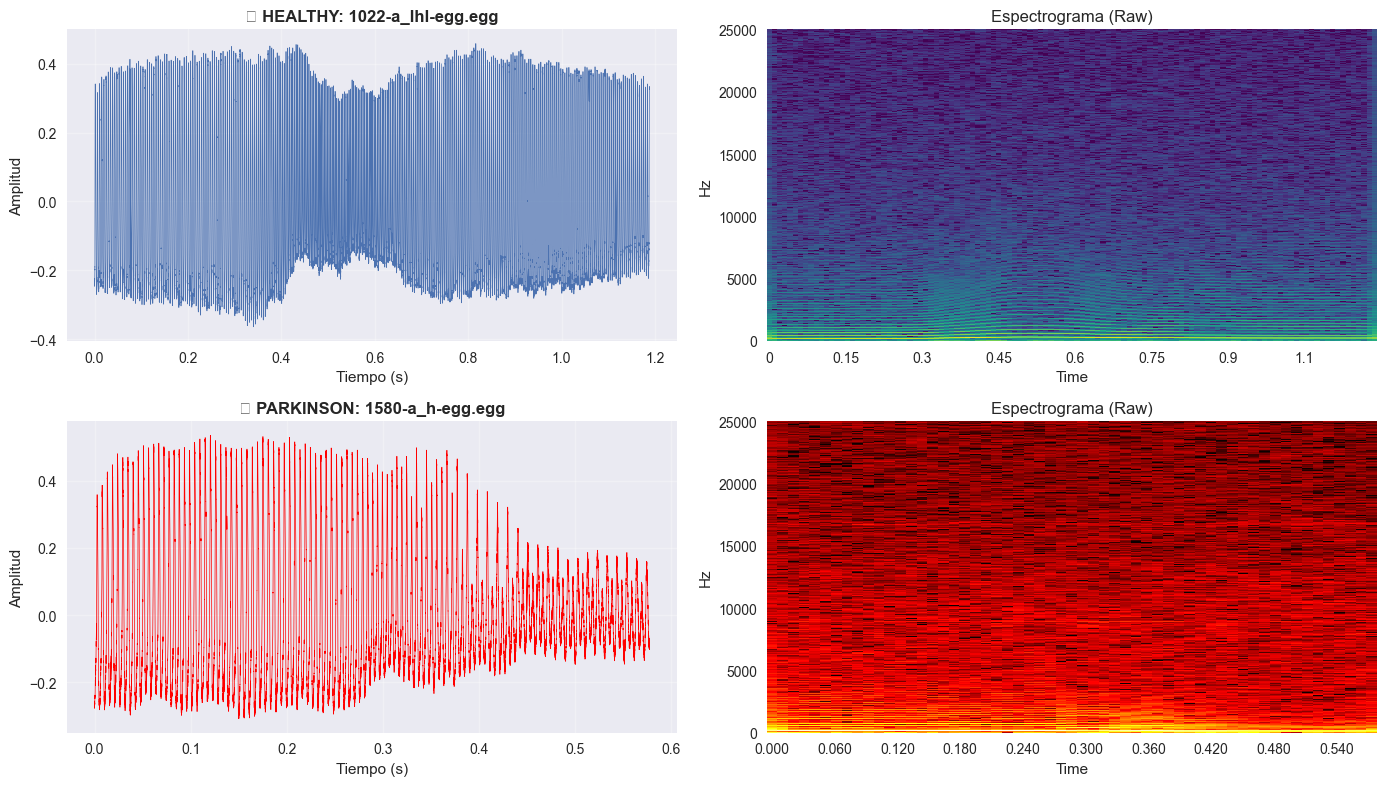

In [3]:
# ============================================================
# VISUALIZAR AUDIO ORIGINAL (SIN PROCESAMIENTO)
# ============================================================

print("="*70)
print("🔊 VISUALIZACIÓN DE AUDIO RAW")
print("="*70)

# Seleccionar un ejemplo de cada clase
example_healthy = audio_files_healthy[0] if audio_files_healthy else None
example_parkinson = audio_files_parkinson[0] if audio_files_parkinson else None

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Visualizar Healthy
if example_healthy:
    y_hc, sr_hc = librosa.load(example_healthy, sr=None)
    
    # Waveform
    axes[0, 0].plot(np.arange(len(y_hc)) / sr_hc, y_hc, linewidth=0.5)
    axes[0, 0].set_title(f"🟢 HEALTHY: {example_healthy.name}", fontweight='bold')
    axes[0, 0].set_xlabel("Tiempo (s)")
    axes[0, 0].set_ylabel("Amplitud")
    axes[0, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_hc = librosa.amplitude_to_db(np.abs(librosa.stft(y_hc)), ref=np.max)
    librosa.display.specshow(D_hc, sr=sr_hc, x_axis='time', y_axis='hz', ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title("Espectrograma (Raw)")
    
    print(f"🟢 Healthy: {example_healthy.name}")
    print(f"   • Duración: {len(y_hc)/sr_hc:.2f}s")
    print(f"   • Sample rate: {sr_hc} Hz")
    print(f"   • Samples: {len(y_hc):,}")

# Visualizar Parkinson
if example_parkinson:
    y_pd, sr_pd = librosa.load(example_parkinson, sr=None)
    
    # Waveform
    axes[1, 0].plot(np.arange(len(y_pd)) / sr_pd, y_pd, linewidth=0.5, color='red')
    axes[1, 0].set_title(f"🔴 PARKINSON: {example_parkinson.name}", fontweight='bold')
    axes[1, 0].set_xlabel("Tiempo (s)")
    axes[1, 0].set_ylabel("Amplitud")
    axes[1, 0].grid(alpha=0.3)
    
    # Espectrograma
    D_pd = librosa.amplitude_to_db(np.abs(librosa.stft(y_pd)), ref=np.max)
    librosa.display.specshow(D_pd, sr=sr_pd, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='hot')
    axes[1, 1].set_title("Espectrograma (Raw)")
    
    print(f"\n🔴 Parkinson: {example_parkinson.name}")
    print(f"   • Duración: {len(y_pd)/sr_pd:.2f}s")
    print(f"   • Sample rate: {sr_pd} Hz")
    print(f"   • Samples: {len(y_pd):,}")

plt.tight_layout()
plt.show()

print("="*70)


## 4. Preprocesamiento Básico

Procesar algunos archivos para ver el pipeline de preprocesamiento.


In [4]:
# ============================================================
# PROCESAMIENTO SEGÚN IBARRA ET AL. (2023)
# ============================================================

print("="*70)
print("PREPROCESAMIENTO BÁSICO (PAPER)")
print("="*70)
print(f"\nPipeline exacto:")
print(f"   1. Resample a {SAMPLE_RATE} Hz")
print(f"   2. Normalización por amplitud máxima absoluta")
print(f"   3. Segmentación: ventanas {WINDOW_MS}ms, overlap {OVERLAP*100:.0f}%")
print(f"   4. Mel spectrogram: {N_MELS} bandas, ventana FFT {FFT_WINDOW}ms, hop {HOP_MS}ms")
print(f"   5. Conversión a dB")
print(f"   6. Normalización z-score por espectrograma")
print(f"   7. Shape final: {N_MELS}×{TARGET_FRAMES}")

# Procesar Healthy (muestra pequeña para visualización)
print(f"\n🟢 Procesando HEALTHY (primeros 3 archivos)...")
dataset_healthy = process_dataset(
    audio_files=audio_files_healthy[:3],
    preprocess_fn=preprocessing.preprocess_audio_paper,
    max_files=None
)

X_healthy_preview, y_task_healthy_preview, y_domain_healthy_preview, meta_healthy_preview = to_pytorch_tensors(dataset_healthy)

print(f"\n   ✅ Healthy procesado:")
print(f"      • Archivos: 3")
print(f"      • Espectrogramas generados: {len(dataset_healthy)}")
print(f"      • Shape tensores: {X_healthy_preview.shape}")

# Procesar Parkinson (muestra pequeña)
print(f"\n🔴 Procesando PARKINSON (primeros 3 archivos)...")
dataset_parkinson = process_dataset(
    audio_files=audio_files_parkinson[:3],
    preprocess_fn=preprocessing.preprocess_audio_paper,
    max_files=None
)

X_parkinson_preview, y_task_parkinson_preview, y_domain_parkinson_preview, meta_parkinson_preview = to_pytorch_tensors(dataset_parkinson)

print(f"\n   ✅ Parkinson procesado:")
print(f"      • Archivos: 3")
print(f"      • Espectrogramas generados: {len(dataset_parkinson)}")
print(f"      • Shape tensores: {X_parkinson_preview.shape}")

print("="*70)


PREPROCESAMIENTO BÁSICO (PAPER)

Pipeline exacto:
   1. Resample a 44100 Hz
   2. Normalización por amplitud máxima absoluta
   3. Segmentación: ventanas 400ms, overlap 50%
   4. Mel spectrogram: 65 bandas, ventana FFT 40ms, hop 10ms
   5. Conversión a dB
   6. Normalización z-score por espectrograma
   7. Shape final: 65×41

🟢 Procesando HEALTHY (primeros 3 archivos)...
🔄 Procesando 3 archivos...
  1/3: 1022-a_lhl-egg.egg
✅ 12 muestras generadas
📊 PyTorch tensors listos:
  - X: (12, 1, 65, 41)
  - y_task: (12,)  (dist={0: 12})
  - y_domain: (12,)  (K dominios=3)

   ✅ Healthy procesado:
      • Archivos: 3
      • Espectrogramas generados: 12
      • Shape tensores: torch.Size([12, 1, 65, 41])

🔴 Procesando PARKINSON (primeros 3 archivos)...
🔄 Procesando 3 archivos...
  1/3: 1580-a_h-egg.egg
✅ 6 muestras generadas
📊 PyTorch tensors listos:
  - X: (6, 1, 65, 41)
  - y_task: (6,)  (dist={0: 6})
  - y_domain: (6,)  (K dominios=3)

   ✅ Parkinson procesado:
      • Archivos: 3
      • Esp

## 5. Visualización de Espectrogramas Procesados

Ver cómo se ven los Mel spectrograms después del preprocesamiento.


📊 VISUALIZACIÓN DE MEL SPECTROGRAMS

🟢 Visualizando muestras de HEALTHY:


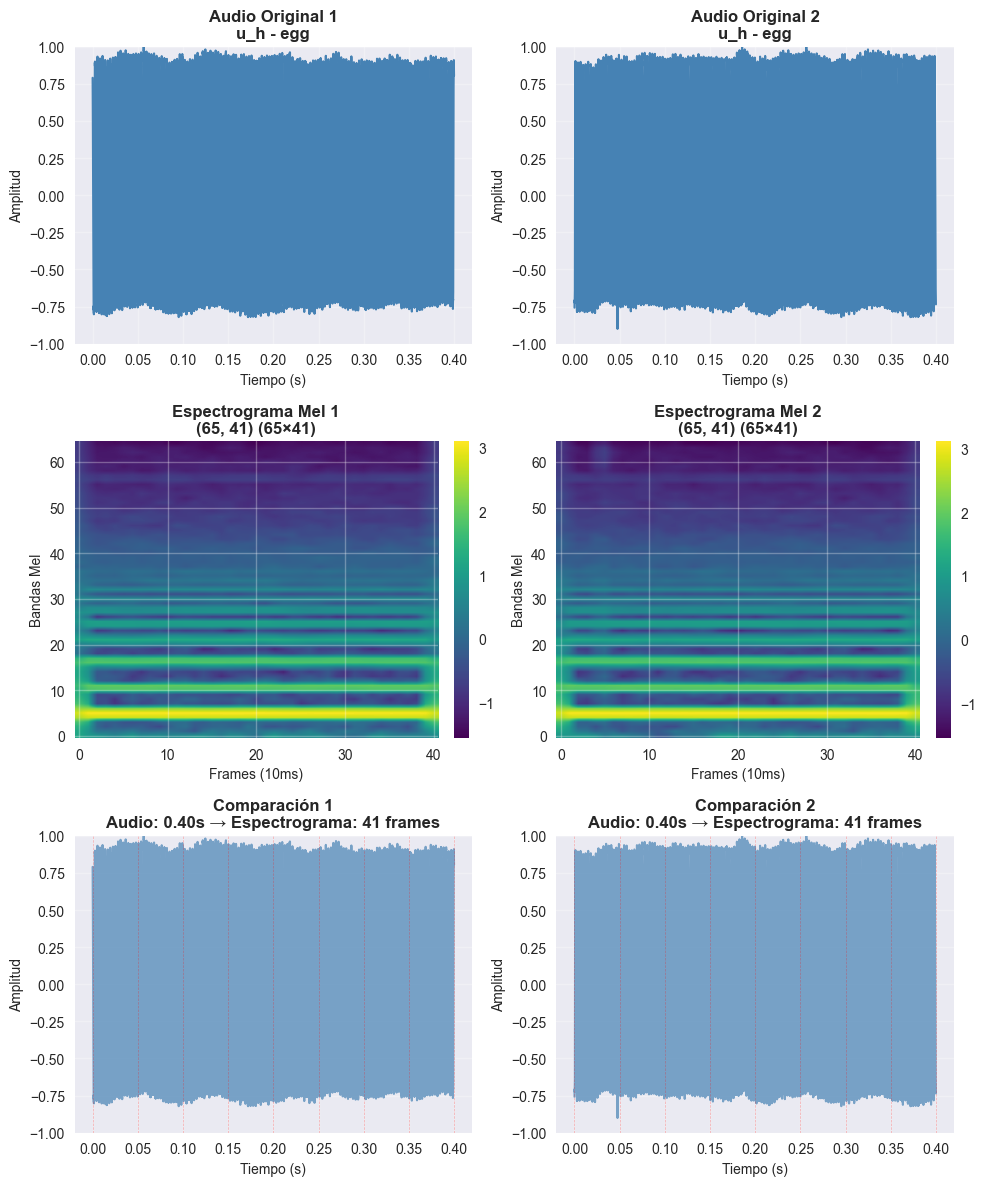


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal u_h
  - Normalización: z-score aplicada
✅ Visualización Healthy completada

🔴 Visualizando muestras de PARKINSON:


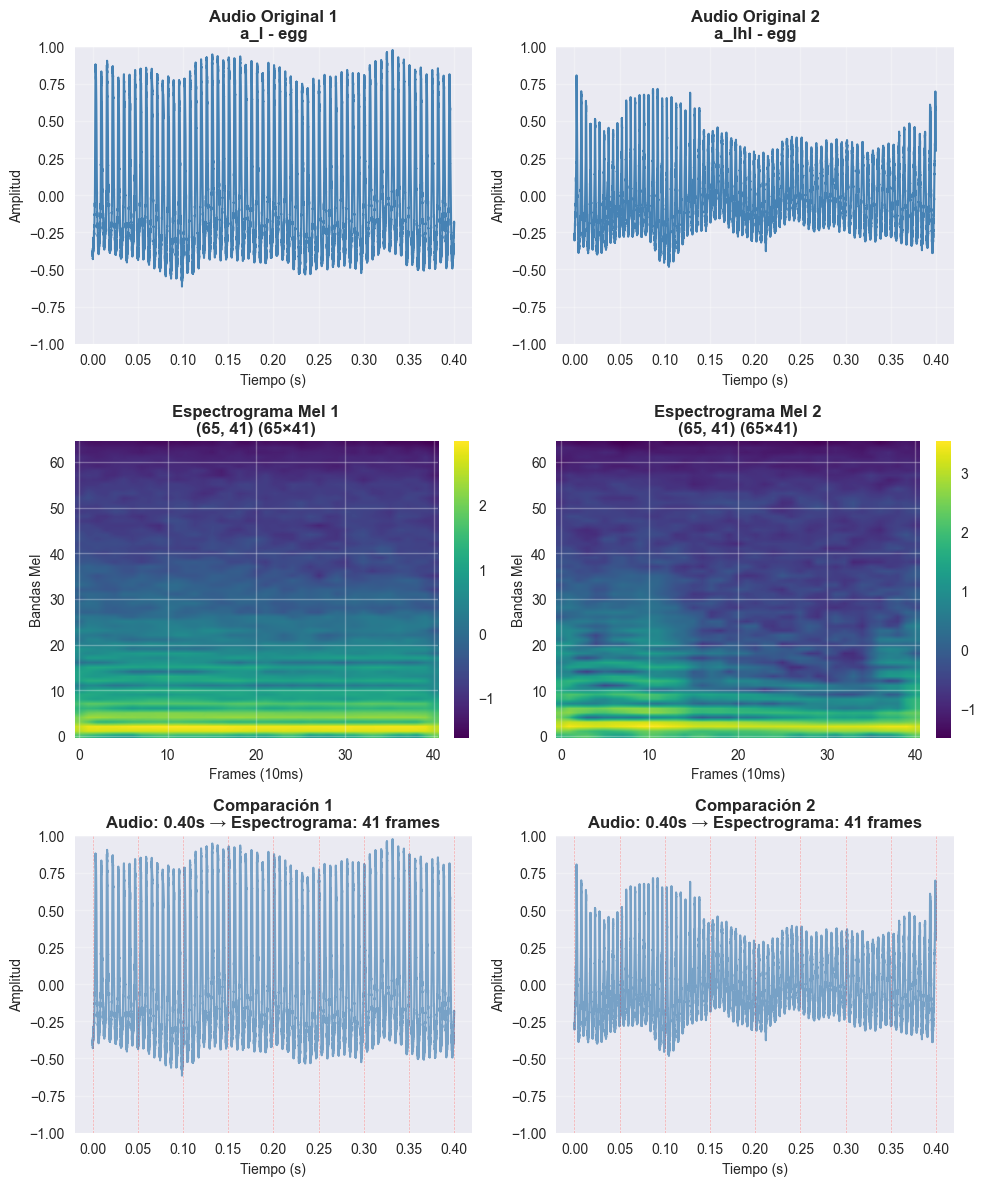


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal a_lhl
  - Normalización: z-score aplicada
✅ Visualización Parkinson completada

💡 Observa las diferencias en patrones entre Healthy y Parkinson


In [5]:
# ============================================================
# VISUALIZAR ESPECTROGRAMAS PROCESADOS
# ============================================================

print("="*70)
print("📊 VISUALIZACIÓN DE MEL SPECTROGRAMS")
print("="*70)

# Visualizar muestras de Healthy
if dataset_healthy and len(dataset_healthy) > 0:
    print("\n🟢 Visualizando muestras de HEALTHY:")
    fig_healthy, audios_healthy = visualize_audio_and_spectrograms(
        dataset_healthy,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("✅ Visualización Healthy completada")

# Visualizar muestras de Parkinson
if dataset_parkinson and len(dataset_parkinson) > 0:
    print("\n🔴 Visualizando muestras de PARKINSON:")
    fig_parkinson, audios_parkinson = visualize_audio_and_spectrograms(
        dataset_parkinson,
        num_samples=2,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    print("✅ Visualización Parkinson completada")

print("\n" + "="*70)
print("💡 Observa las diferencias en patrones entre Healthy y Parkinson")
print("="*70)


## 6. Procesamiento Completo de Datos

Procesar TODOS los archivos y guardar en cache para reutilización.


In [6]:
# ============================================================
# CONFIGURACIÓN DE CACHE
# ============================================================

CACHE_DIR = "./cache"
CACHE_HEALTHY = f"{CACHE_DIR}/healthy_ibarra.pkl"
CACHE_PARKINSON = f"{CACHE_DIR}/parkinson_ibarra.pkl"

# Crear directorio de cache si no existe
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

print("="*70)
print("CONFIGURACIÓN DE CACHE")
print("="*70)
print(f"\n💾 Directorios de cache:")
print(f"   • Healthy: {CACHE_HEALTHY}")
print(f"   • Parkinson: {CACHE_PARKINSON}")
print("\n📋 Los espectrogramas individuales (65×41) serán guardados y")
print("   reutilizados para CNN2D y Time-CNN-LSTM.")
print("="*70)


CONFIGURACIÓN DE CACHE

💾 Directorios de cache:
   • Healthy: ./cache/healthy_ibarra.pkl
   • Parkinson: ./cache/parkinson_ibarra.pkl

📋 Los espectrogramas individuales (65×41) serán guardados y
   reutilizados para CNN2D y Time-CNN-LSTM.


## 7. Procesar Healthy - Todos los archivos


In [7]:
# ============================================================
# PROCESAR HEALTHY - TODOS LOS ARCHIVOS
# ============================================================

print("\n" + "="*70)
print("🟢 PROCESANDO HEALTHY - TODOS LOS ARCHIVOS")
print("="*70)

# Intentar cargar desde cache
dataset_healthy_full = load_spectrograms_cache(CACHE_HEALTHY)

if dataset_healthy_full is None:
    print("\n📂 Cache no encontrado. Procesando archivos...")
    
    # Procesar todos los archivos healthy
    dataset_healthy_full = process_dataset(
        audio_files=audio_files_healthy,
        preprocess_fn=preprocessing.preprocess_audio_paper,
        progress_every=3
    )
    
    # Guardar en cache
    save_spectrograms_cache(dataset_healthy_full, CACHE_HEALTHY)
else:
    print("⚡ Datos cargados desde cache")

# Convertir a tensores
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(dataset_healthy_full)

print(f"\n✅ HEALTHY COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_healthy)}")
print(f"   • Espectrogramas generados: {len(dataset_healthy_full)}")
print(f"   • Shape: {X_healthy.shape}")
print(f"   • Espectrogramas por archivo (promedio): {len(dataset_healthy_full)/len(audio_files_healthy):.1f}")
print("="*70)



🟢 PROCESANDO HEALTHY - TODOS LOS ARCHIVOS

📂 Cache no encontrado. Procesando archivos...
🔄 Procesando 13 archivos...
  1/13: 1022-a_lhl-egg.egg
  4/13: 1135-i_n-egg.egg
  7/13: 1520-i_l-egg.egg
  10/13: 2252-u_lhl-egg.egg
  13/13: 97-a_h-egg.egg
✅ 155 muestras generadas

💾 Cache guardado: ./cache/healthy_ibarra.pkl
   Tamaño: 12.0 MB
   Muestras: 155
📊 PyTorch tensors listos:
  - X: (155, 1, 65, 41)
  - y_task: (155,)  (dist={0: 155})
  - y_domain: (155,)  (K dominios=13)

✅ HEALTHY COMPLETADO:
   • Archivos originales: 13
   • Espectrogramas generados: 155
   • Shape: torch.Size([155, 1, 65, 41])
   • Espectrogramas por archivo (promedio): 11.9


## 8. Procesar Parkinson - Todos los archivos


In [8]:
# ============================================================
# PROCESAR PARKINSON - TODOS LOS ARCHIVOS
# ============================================================

print("\n" + "="*70)
print("🔴 PROCESANDO PARKINSON - TODOS LOS ARCHIVOS")
print("="*70)

# Intentar cargar desde cache
dataset_parkinson_full = load_spectrograms_cache(CACHE_PARKINSON)

if dataset_parkinson_full is None:
    print("\n📂 Cache no encontrado. Procesando archivos...")
    
    # Procesar todos los archivos parkinson
    dataset_parkinson_full = process_dataset(
        audio_files=audio_files_parkinson,
        preprocess_fn=preprocessing.preprocess_audio_paper,
        progress_every=3
    )
    
    # Guardar en cache
    save_spectrograms_cache(dataset_parkinson_full, CACHE_PARKINSON)
else:
    print("⚡ Datos cargados desde cache")

# Convertir a tensores
X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(dataset_parkinson_full)

print(f"\n✅ PARKINSON COMPLETADO:")
print(f"   • Archivos originales: {len(audio_files_parkinson)}")
print(f"   • Espectrogramas generados: {len(dataset_parkinson_full)}")
print(f"   • Shape: {X_parkinson.shape}")
print(f"   • Espectrogramas por archivo (promedio): {len(dataset_parkinson_full)/len(audio_files_parkinson):.1f}")
print("="*70)



🔴 PROCESANDO PARKINSON - TODOS LOS ARCHIVOS

📂 Cache no encontrado. Procesando archivos...
🔄 Procesando 13 archivos...
  1/13: 1580-a_h-egg.egg
  4/13: 1580-a_n-egg.egg
  7/13: 1580-i_l-egg.egg
  10/13: 1580-u_h-egg.egg
  13/13: 1580-u_n-egg.egg
✅ 121 muestras generadas

💾 Cache guardado: ./cache/parkinson_ibarra.pkl
   Tamaño: 9.4 MB
   Muestras: 121
📊 PyTorch tensors listos:
  - X: (121, 1, 65, 41)
  - y_task: (121,)  (dist={0: 121})
  - y_domain: (121,)  (K dominios=13)

✅ PARKINSON COMPLETADO:
   • Archivos originales: 13
   • Espectrogramas generados: 121
   • Shape: torch.Size([121, 1, 65, 41])
   • Espectrogramas por archivo (promedio): 9.3


In [9]:
# ============================================================
# RESUMEN DEL PREPROCESAMIENTO
# ============================================================

print("\n" + "="*70)
print("RESUMEN DE PREPROCESAMIENTO")
print("="*70)

print(f"\n🎯 DATOS GENERADOS:")
print(f"   🟢 Healthy:   {X_healthy.shape[0]:4d} espectrogramas | Shape: {tuple(X_healthy.shape[1:])}")
print(f"   🔴 Parkinson: {X_parkinson.shape[0]:4d} espectrogramas | Shape: {tuple(X_parkinson.shape[1:])}")
print(f"   📊 Total:     {X_healthy.shape[0] + X_parkinson.shape[0]:4d} espectrogramas")

balance_pct = X_parkinson.shape[0] / (X_healthy.shape[0] + X_parkinson.shape[0]) * 100
print(f"\n📈 BALANCE:")
print(f"   • Parkinson: {balance_pct:.1f}%")
print(f"   • Healthy: {100-balance_pct:.1f}%")

print(f"\n💾 CACHE GUARDADO:")
print(f"   • {CACHE_HEALTHY}")
print(f"   • {CACHE_PARKINSON}")

print(f"\n✅ Pipeline completado según Ibarra et al. (2023)")
print(f"   • Sin augmentation")
print(f"   • Normalización por max-abs + z-score individual")
print(f"   • Espectrogramas reutilizables para CNN2D y Time-CNN-LSTM")
print("="*70)



RESUMEN DE PREPROCESAMIENTO

🎯 DATOS GENERADOS:
   🟢 Healthy:    155 espectrogramas | Shape: (1, 65, 41)
   🔴 Parkinson:  121 espectrogramas | Shape: (1, 65, 41)
   📊 Total:      276 espectrogramas

📈 BALANCE:
   • Parkinson: 43.8%
   • Healthy: 56.2%

💾 CACHE GUARDADO:
   • ./cache/healthy_ibarra.pkl
   • ./cache/parkinson_ibarra.pkl

✅ Pipeline completado según Ibarra et al. (2023)
   • Sin augmentation
   • Normalización por max-abs + z-score individual
   • Espectrogramas reutilizables para CNN2D y Time-CNN-LSTM


In [10]:
# ============================================================
# PRÓXIMOS PASOS
# ============================================================

print("\n" + "="*70)
print("PRÓXIMOS PASOS")
print("="*70)

print(f"\n🚀 Notebooks de entrenamiento:")
print(f"   1. cnn_training.ipynb       → CNN2D sin Domain Adaptation")
print(f"   2. cnn_da_training.ipynb    → CNN2D con Domain Adaptation")
print(f"   3. cnn1d_da_training.ipynb  → CNN1D (arquitectura actual)")
print(f"   4. time_cnn_lstm_training.ipynb → Time-CNN-BiLSTM (NUEVO)")

print(f"\n📋 Uso de espectrogramas:")
print(f"   • CNN2D: Un espectrograma (1, 65, 41) por input")
print(f"   • Time-CNN-LSTM: Secuencias de n espectrogramas con padding/masking")
print(f"   • Probar n ∈ {{3, 5, 7, 9}} según paper")

print(f"\n💡 Los datos ya están listos y en cache!")
print("="*70)



PRÓXIMOS PASOS

🚀 Notebooks de entrenamiento:
   1. cnn_training.ipynb       → CNN2D sin Domain Adaptation
   2. cnn_da_training.ipynb    → CNN2D con Domain Adaptation
   3. cnn1d_da_training.ipynb  → CNN1D (arquitectura actual)
   4. time_cnn_lstm_training.ipynb → Time-CNN-BiLSTM (NUEVO)

📋 Uso de espectrogramas:
   • CNN2D: Un espectrograma (1, 65, 41) por input
   • Time-CNN-LSTM: Secuencias de n espectrogramas con padding/masking
   • Probar n ∈ {3, 5, 7, 9} según paper

💡 Los datos ya están listos y en cache!


## 9. Fin del Preprocesamiento

Los datos están listos para entrenar modelos.


In [11]:
# ============================================================
# FIN DEL PREPROCESAMIENTO
# ============================================================

print("\n" + "="*70)
print("✅ PREPROCESAMIENTO COMPLETADO")
print("="*70)

print(f"\n📊 Datos según Ibarra et al. (2023):")
print(f"   • Pipeline: resample → norm max-abs → segment → Mel → dB → z-score")
print(f"   • Sin augmentation (solo preprocesamiento paper)")
print(f"   • Espectrogramas: {X_healthy.shape[0] + X_parkinson.shape[0]} totales")
print(f"   • Dimensión: 65×41 píxeles")

print(f"\n💾 Cache disponible para reutilización rápida")
print(f"\n🚀 Listo para entrenar CNN2D y Time-CNN-LSTM")
print("="*70)



✅ PREPROCESAMIENTO COMPLETADO

📊 Datos según Ibarra et al. (2023):
   • Pipeline: resample → norm max-abs → segment → Mel → dB → z-score
   • Sin augmentation (solo preprocesamiento paper)
   • Espectrogramas: 276 totales
   • Dimensión: 65×41 píxeles

💾 Cache disponible para reutilización rápida

🚀 Listo para entrenar CNN2D y Time-CNN-LSTM


## 10. Notas Finales

Referencias al paper de Ibarra et al. (2023)


In [12]:
# ============================================================
# NOTAS FINALES
# ============================================================

print("\n" + "="*70)
print("REFERENCIA")
print("="*70)

print(f"\n📚 Paper implementado:")
print(f"   'Towards a Corpus (and Language)-Independent Screening of")
print(f"    Parkinson's Disease from Voice and Speech through Domain Adaptation'")
print(f"   Ibarra et al. (2023)")

print(f"\n📋 Preprocesamiento exacto:")
print(f"   1. Resample a 44.1 kHz")
print(f"   2. Normalización por amplitud máxima absoluta")
print(f"   3. Segmentación: 400ms ventanas, 50% overlap")
print(f"   4. Mel spectrogram: 65 bandas, ventana FFT 40ms, hop 10ms")
print(f"   5. Conversión a dB")
print(f"   6. Normalización z-score por espectrograma individual")
print(f"   7. Dimensión: 65×41 píxeles")

print(f"\n✅ Sin augmentation (tal como especifica el paper)")
print("="*70)



REFERENCIA

📚 Paper implementado:
   'Towards a Corpus (and Language)-Independent Screening of
    Parkinson's Disease from Voice and Speech through Domain Adaptation'
   Ibarra et al. (2023)

📋 Preprocesamiento exacto:
   1. Resample a 44.1 kHz
   2. Normalización por amplitud máxima absoluta
   3. Segmentación: 400ms ventanas, 50% overlap
   4. Mel spectrogram: 65 bandas, ventana FFT 40ms, hop 10ms
   5. Conversión a dB
   6. Normalización z-score por espectrograma individual
   7. Dimensión: 65×41 píxeles

✅ Sin augmentation (tal como especifica el paper)
